In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from scalp_utils import *
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import scipy.stats as sp_stats
plt.style.use('dark_background')
mne.viz.set_browser_backend('qt')

'qt'

In [65]:
subj = '39'
y_subj = get_all_y_AH(subjects=[subj])
clear_output()
print(len(y_subj))
print(y_subj.sum())

70627
1795.0


In [66]:
feat_eog1 = get_all_feat_eog_with_chan_feat('1', subjects=[subj])
clear_output()
feat_eog2 = get_all_feat_eog_with_chan_feat('2', subjects=[subj])
clear_output()

In [67]:
subj_feat = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

# under sampling non-spikes epochs
subj_feat['y'] = y_subj.astype(int)
feat_0 = subj_feat[subj_feat['y'] == 0].sample(n=int(y_subj.sum()))
feat_1 = subj_feat[subj_feat['y'] == 1].sample(n=int(y_subj.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_under = feat_under['y'].to_numpy()
subj_feat = subj_feat.drop('y', axis=1)
feat_under = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_under, y_under, random_state=20)

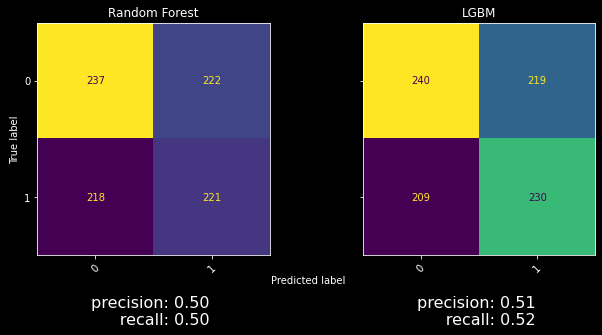

In [68]:
prob=None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

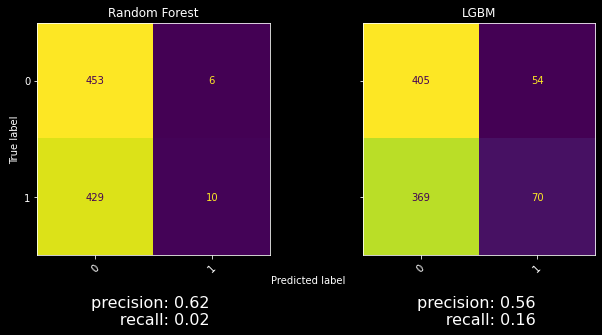

In [69]:
prob=0.7
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [73]:
# features = np.nan_to_num(features[model_lgbm.feature_name_])
# subj_feat = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

# y_lgbm = classifiers['LGBM'].predict(subj_feat.iloc[:, 2:])
y_lgbm = classifiers['LGBM'].predict_proba(subj_feat.iloc[:, 2:]).T
y_lgbm = [p > 0.85 for p in y_lgbm[1]]

y_rf = classifiers['Random Forest'].predict_proba(subj_feat.iloc[:, 2:]).T
y_rf = [p > 0.85 for p in y_rf[1]]
y_scalp = np.array(y_lgbm) + np.array(y_rf)
y_scalp[y_scalp == 2] = 1
scalp_onsets = np.where(y_scalp == 1)[0] / 4
depth_onsets = np.where(y_subj == 1)[0] / 4
both = [x for x in scalp_onsets if x in depth_onsets]
raw = mne.io.read_raw_edf(scalp_edf_path % subj)
# all annot
annot = mne.Annotations(scalp_onsets, [0.25] * len(scalp_onsets), ['scalp'] * len(scalp_onsets)).append(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
# only depth and both
# annot = mne.Annotations(depth_onsets, [0.25] * len(depth_onsets), ['depth'] * len(depth_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
raw.set_annotations(annot)
# mne.set_bipolar_reference(raw, raw.ch_names[0], raw.ch_names[1], ch_name='bi', drop_refs=False).plot(
#     duration=30, scalings='auto')

raw.pick_channels([x for x in raw.ch_names if 'EOG' in x or 'AH' in x]).crop(tmax=60*120).plot(duration=30, scalings='auto')

Extracting EDF parameters from C:\UCLA\39_clean_eog.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [72]:
print(len(depth_onsets))
print(len(scalp_onsets))
print(len(both))
print(len(y_lgbm))

1795
1738
558
70627


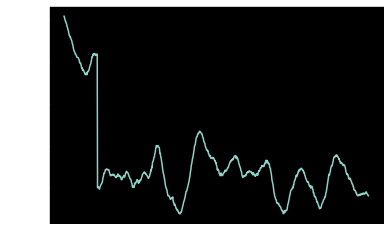

In [15]:
data = raw.copy().crop(tmin=550, tmax=551).get_data()[0]
plt.plot(data)

In [17]:
from scipy import stats

z_score_amp = stats.zscore(np.ediff1d(data))
z_score_amp
points_above_thresh_amp = z_score_amp[abs(z_score_amp) > 10]

In [18]:
points_above_thresh_amp

array([-30.55771693])

In [19]:
np.where(abs(z_score_amp) >10)

(array([109], dtype=int64),)

In [21]:
np.where(z_score_amp == max(z_score_amp, key=abs))

(array([109], dtype=int64),)

In [15]:
grad = np.diff(data)
grad[abs(grad) > 10]

array([], dtype=float64)

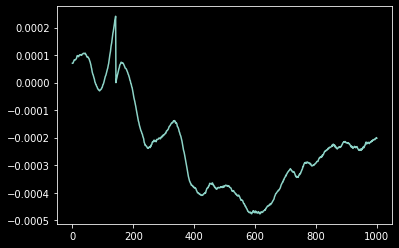

In [21]:
data = raw.copy().crop(tmin=715, tmax=716).get_data()[0]
plt.plot(data)

In [22]:
z_score_grad = stats.zscore(np.ediff1d(data))
np.where(abs(z_score_grad) >10)

(array([142], dtype=int64),)